In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from hq.samples_analysis import extract_MAP_sample

os.environ['APOGEE_CACHE_PATH'] = '/mnt/ceph/users/apricewhelan/apogee'
from subframe.data import Visit
from subframe.config import sdss_auth, plot_path, allstar_path, allvisit_path
from subframe.log import logger
from subframe.velocity import (normalize_ref_to_frame, cross_correlate, 
                               estimate_kernel, bag_of_hacks_cross_correlate)
from subframe.utils import parabola_optimum
from subframe.plot import plot_spectrum_masked, plot_visit_frames, plot_normalized_ref_spectrum

# logger.setLevel(1)

In [2]:
allstar = at.Table.read(allstar_path, hdu=1)
allvisit = at.Table.read(allvisit_path, hdu=1)

In [3]:
# apid = '2M19241171+3650235' # KOI-984
# apid = '2M11291785+4853250' # variable control star
# apid = tmp_id  # see above
# apid = '2M07273995+2420118'  # HAT-P-20
# apid = '2M14272096+0906415'  # null

# short-period Joker
apid = '2M03322788-0658199'
P = 0.7087199091911316

star = allstar[allstar['APOGEE_ID'] == apid]
visits_tbl = allvisit[allvisit['APOGEE_ID'] == apid]
len(visits_tbl)

12

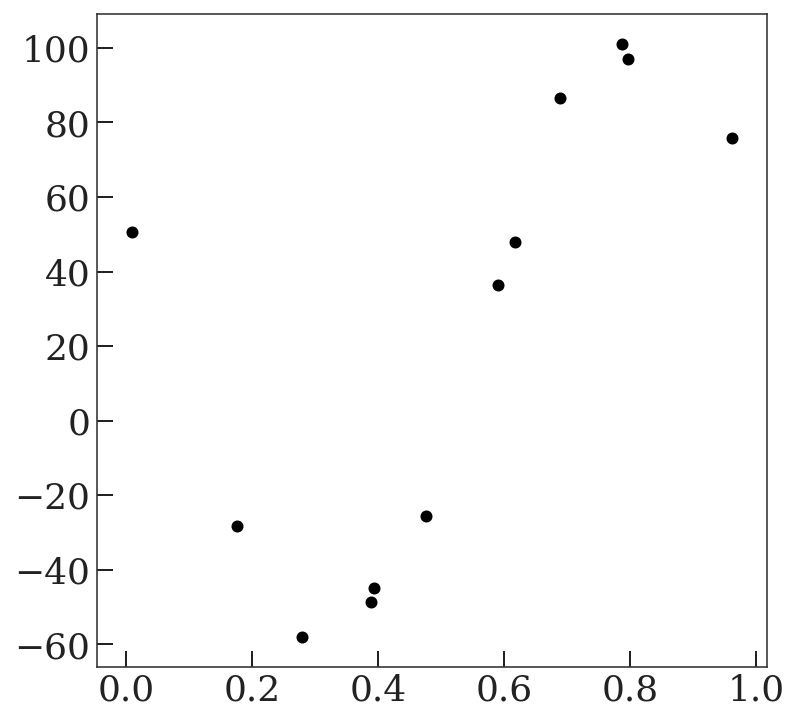

In [4]:
# plt.scatter((visits['JD'] / 0.9631649255752563) % 1., visits['VHELIO'])
# plt.scatter((row['JD'] / 0.9631649255752563) % 1., row['VHELIO'], color='tab:red')
plt.scatter((visits_tbl['JD'] / P) % 1, visits_tbl['VHELIO'])

In [5]:
visits = []
for row in visits_tbl:
    visit = Visit(row)
    frames = visit.frame_hdulists
    if frames is not None:
        visits.append(visit)
len(visits)

10

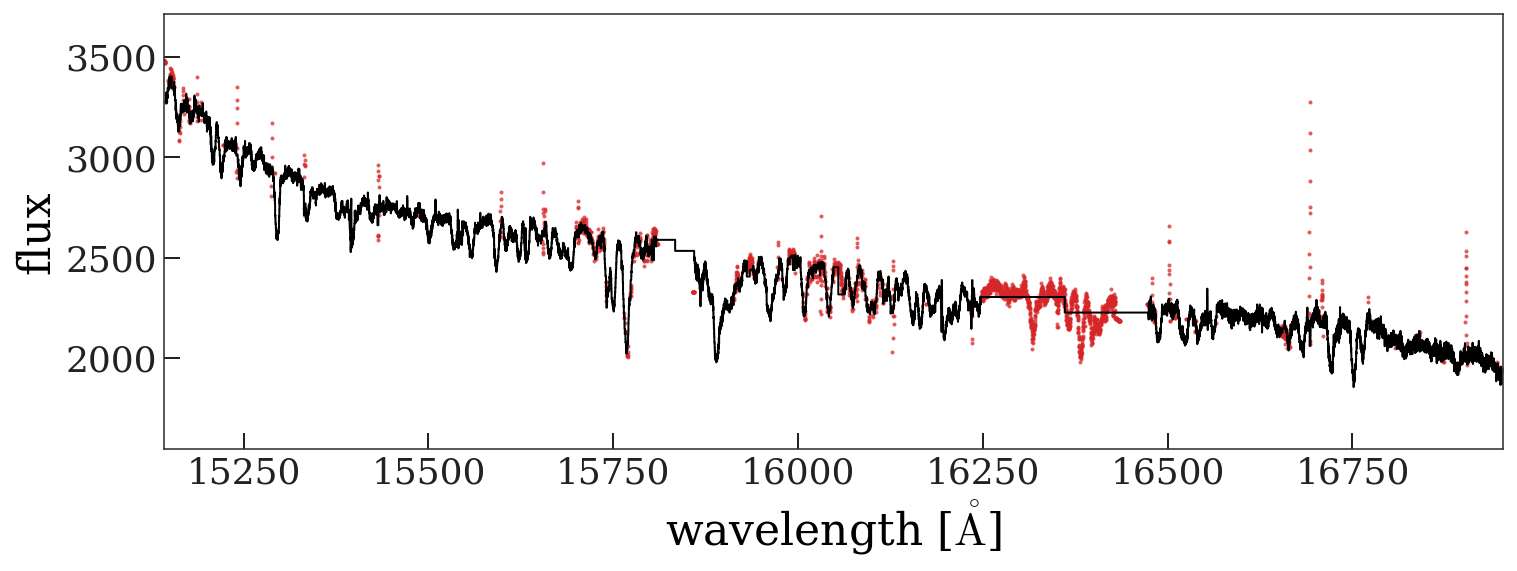

In [6]:
for visit in visits:
    fig = plot_spectrum_masked(visit.get_spectrum())
    break

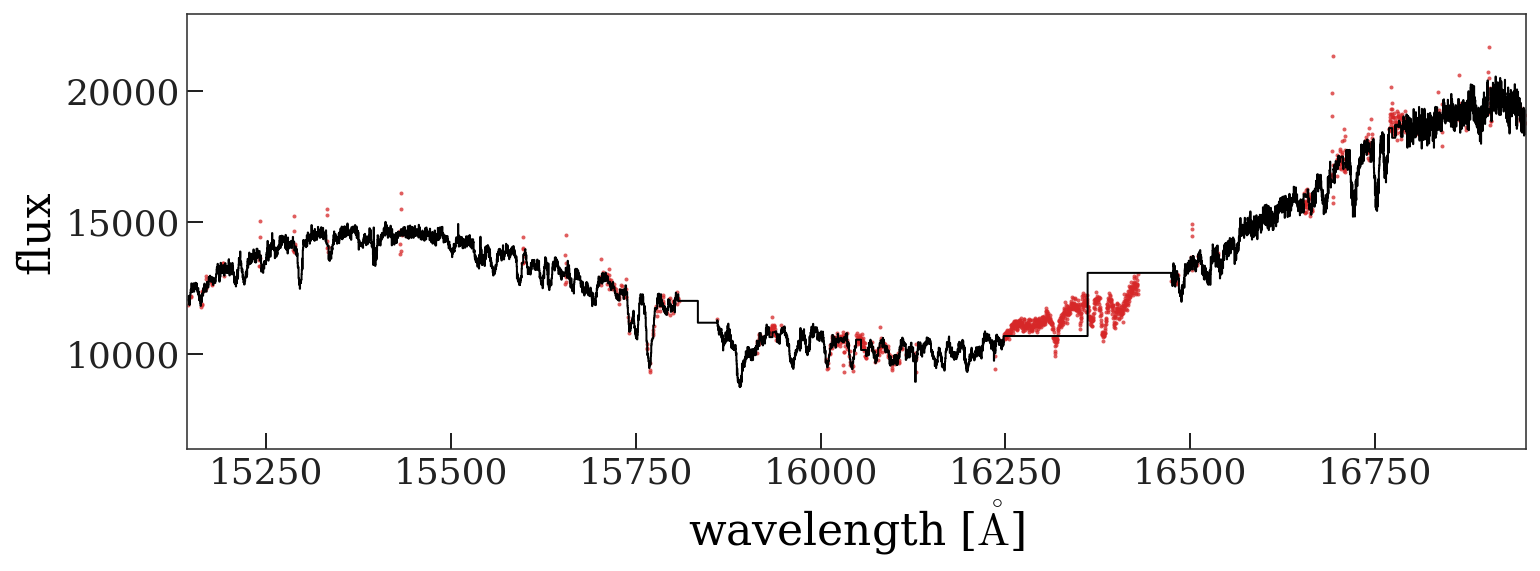

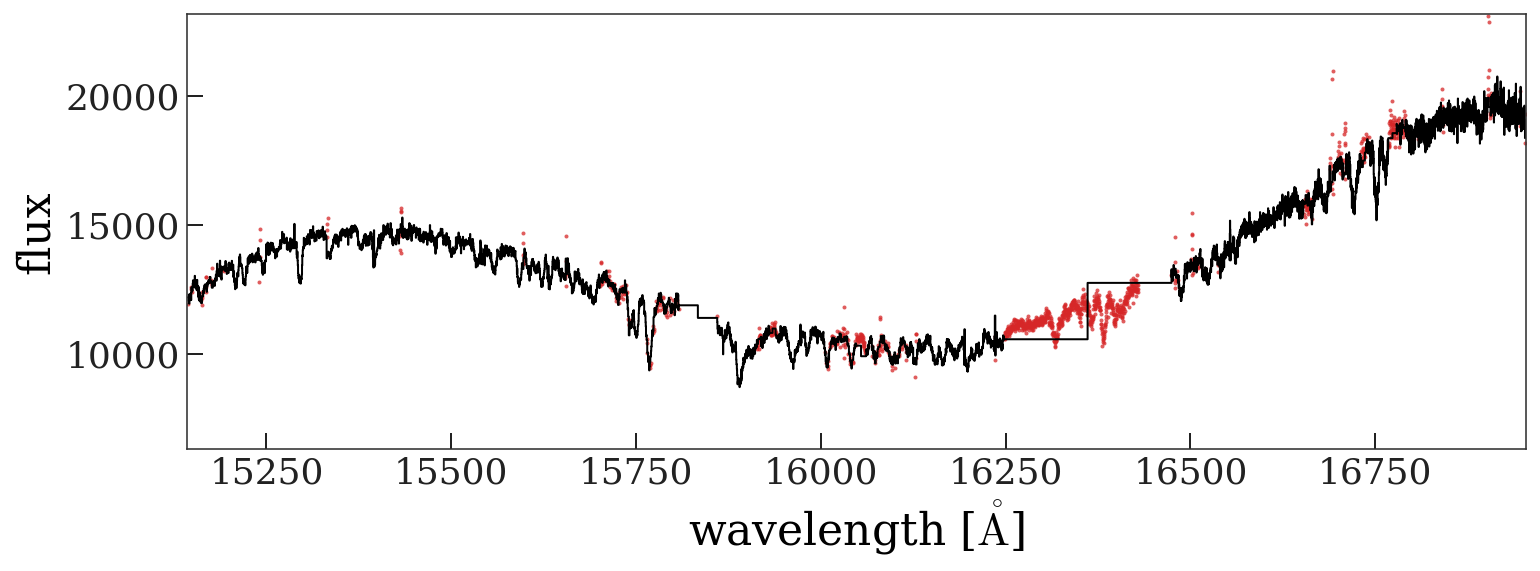

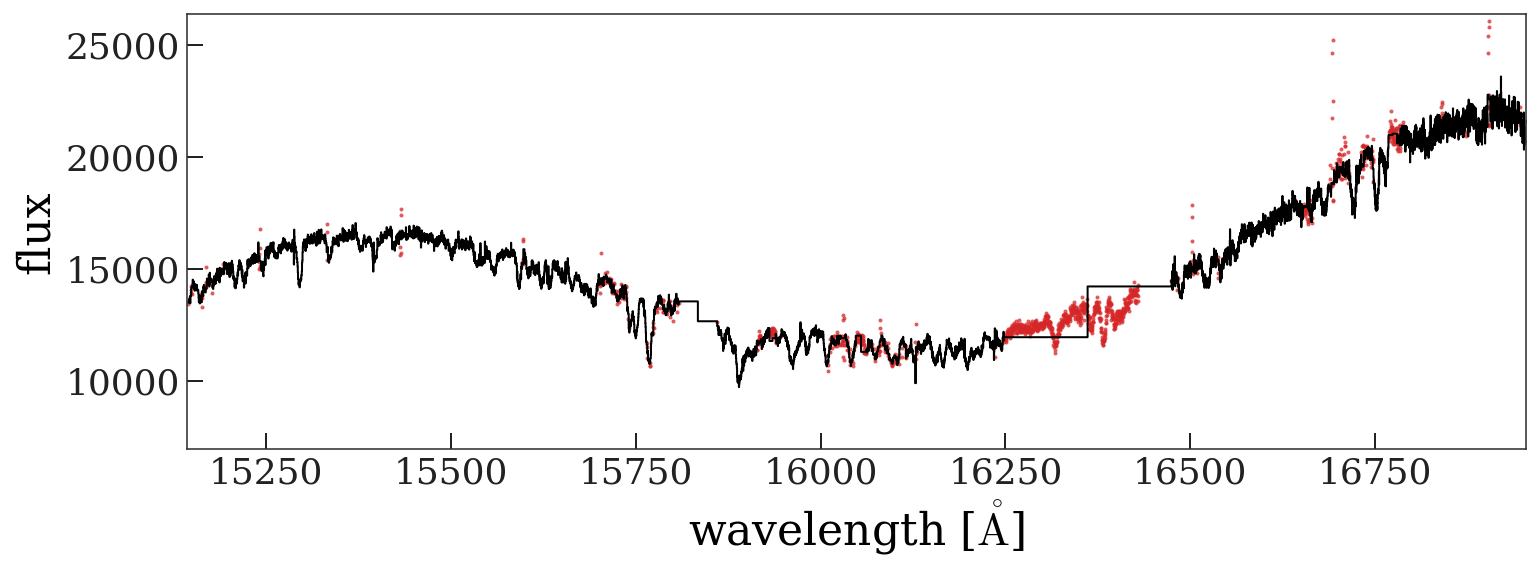

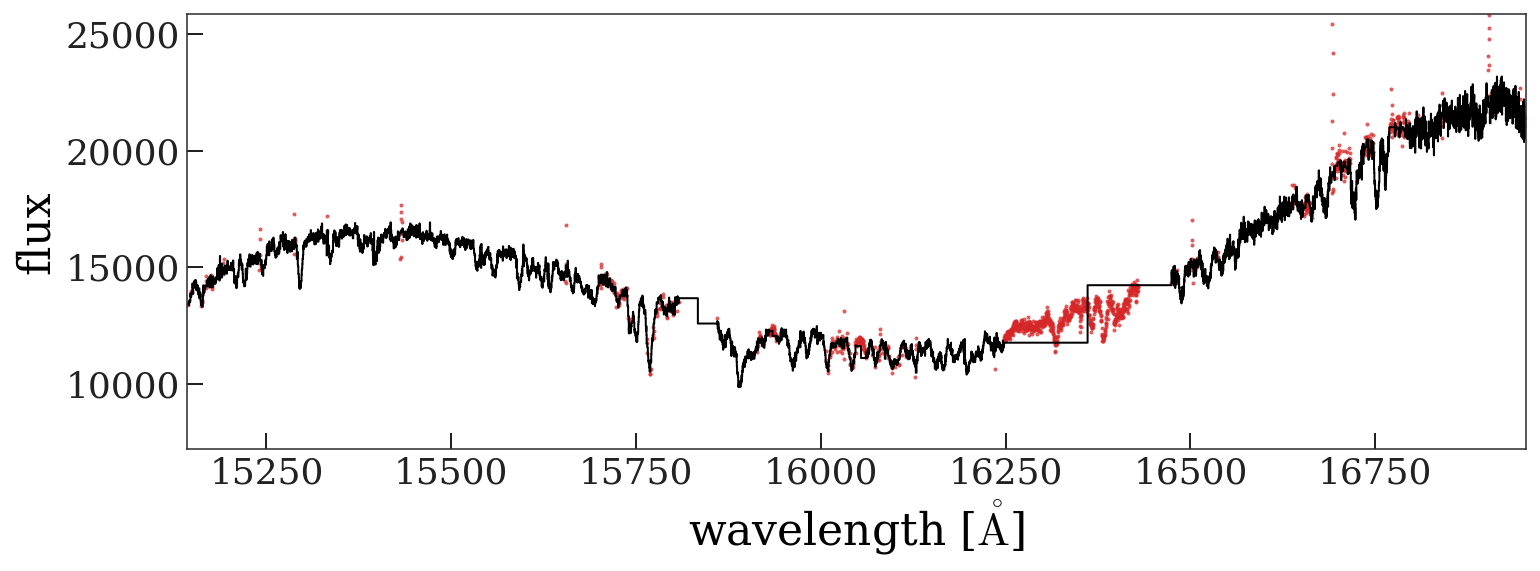

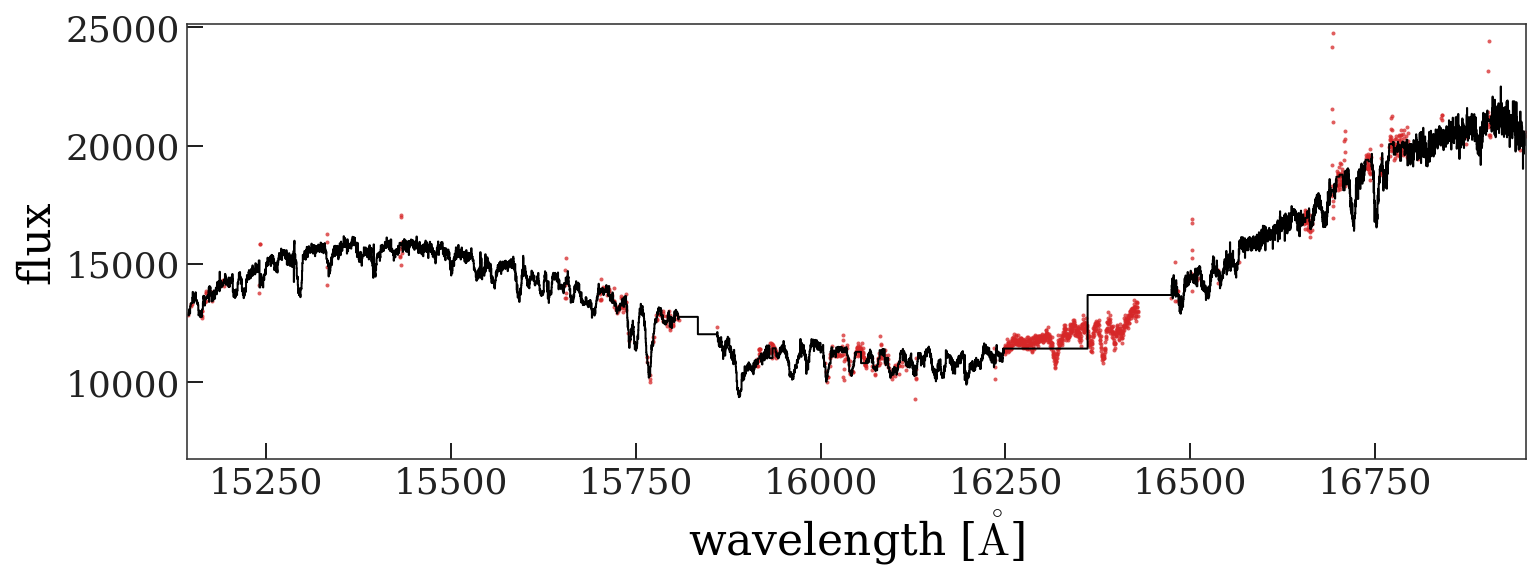

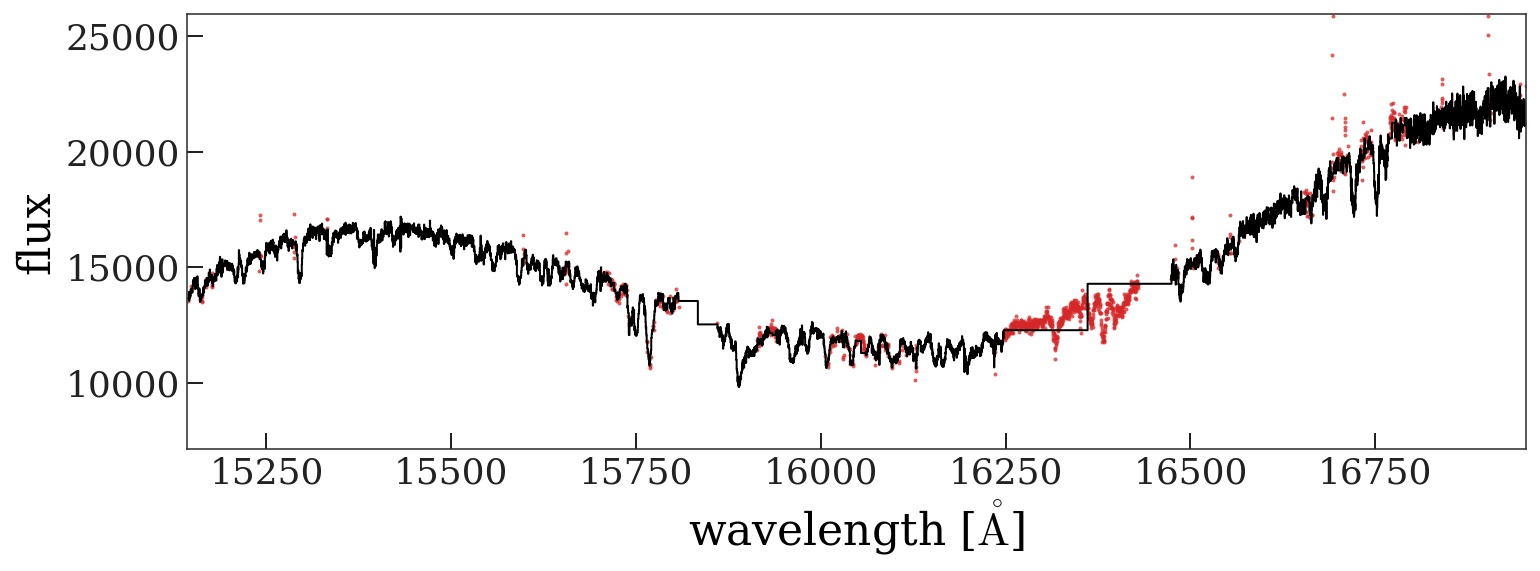

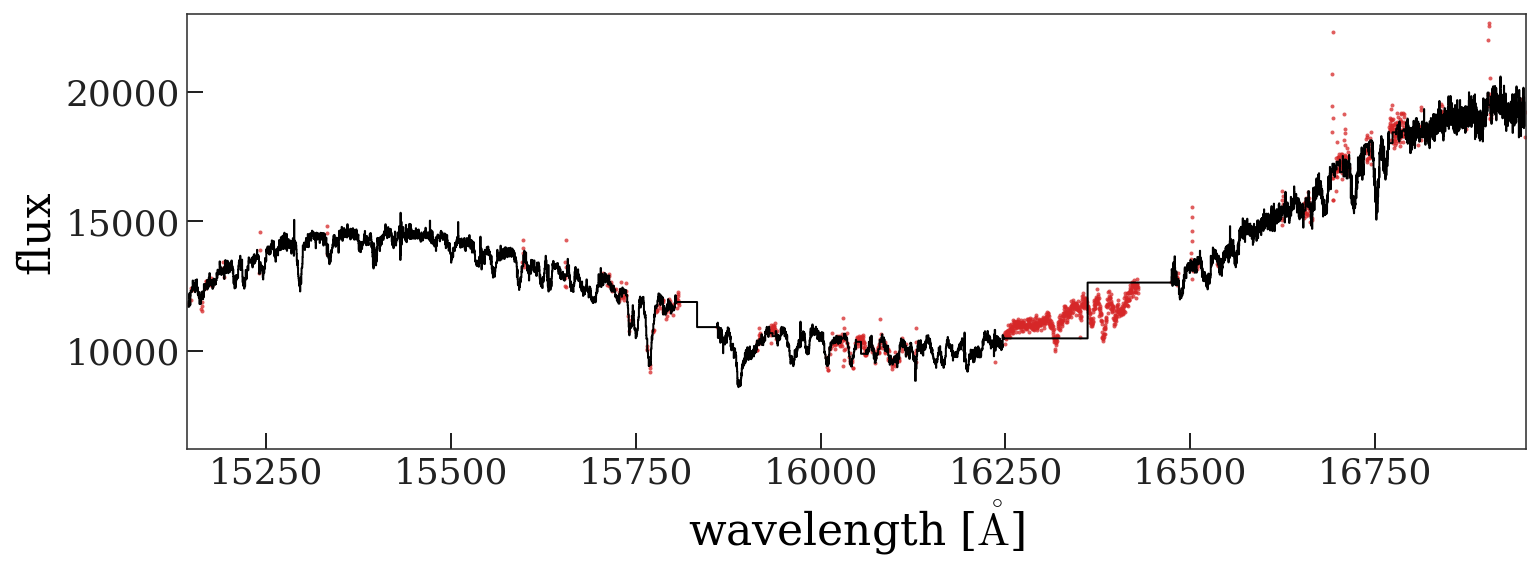

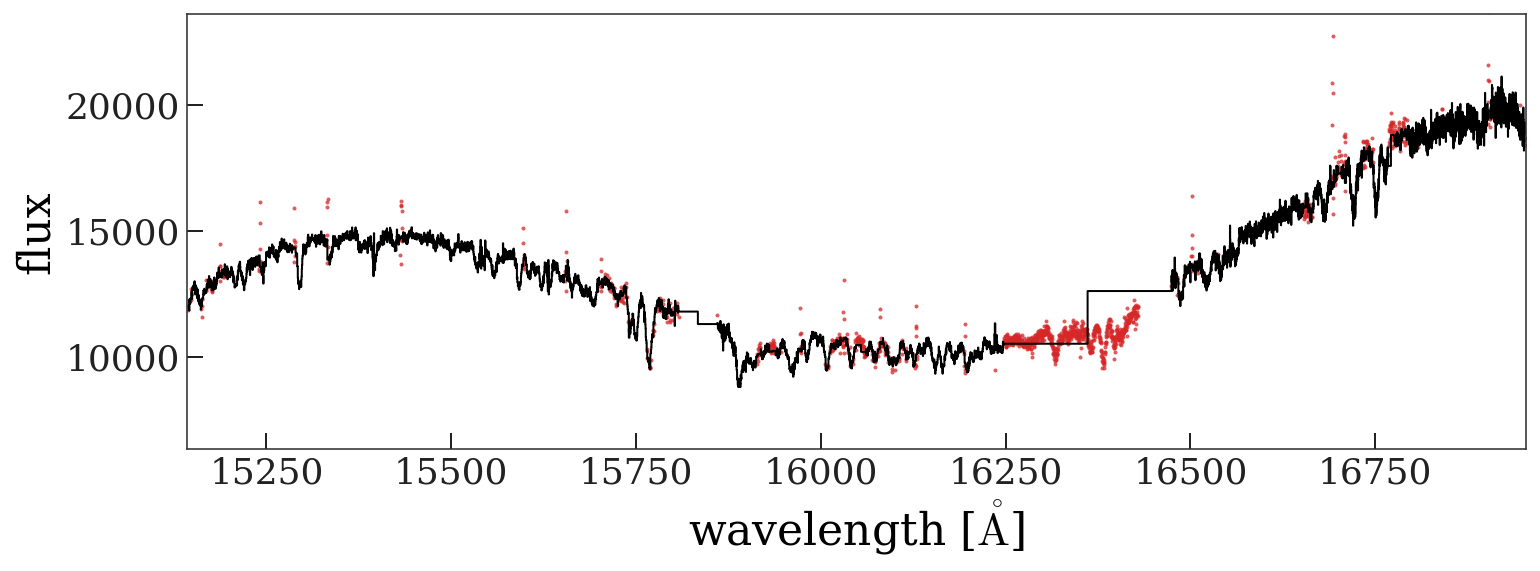

In [9]:
for visit in visits:
    # frame_spectra = visit.get_frame_spectra(percentile_clip=False)
    frame_spectra = visit.get_frame_spectra()
    for k, s in frame_spectra.items():
        fig = plot_spectrum_masked(s)
    break

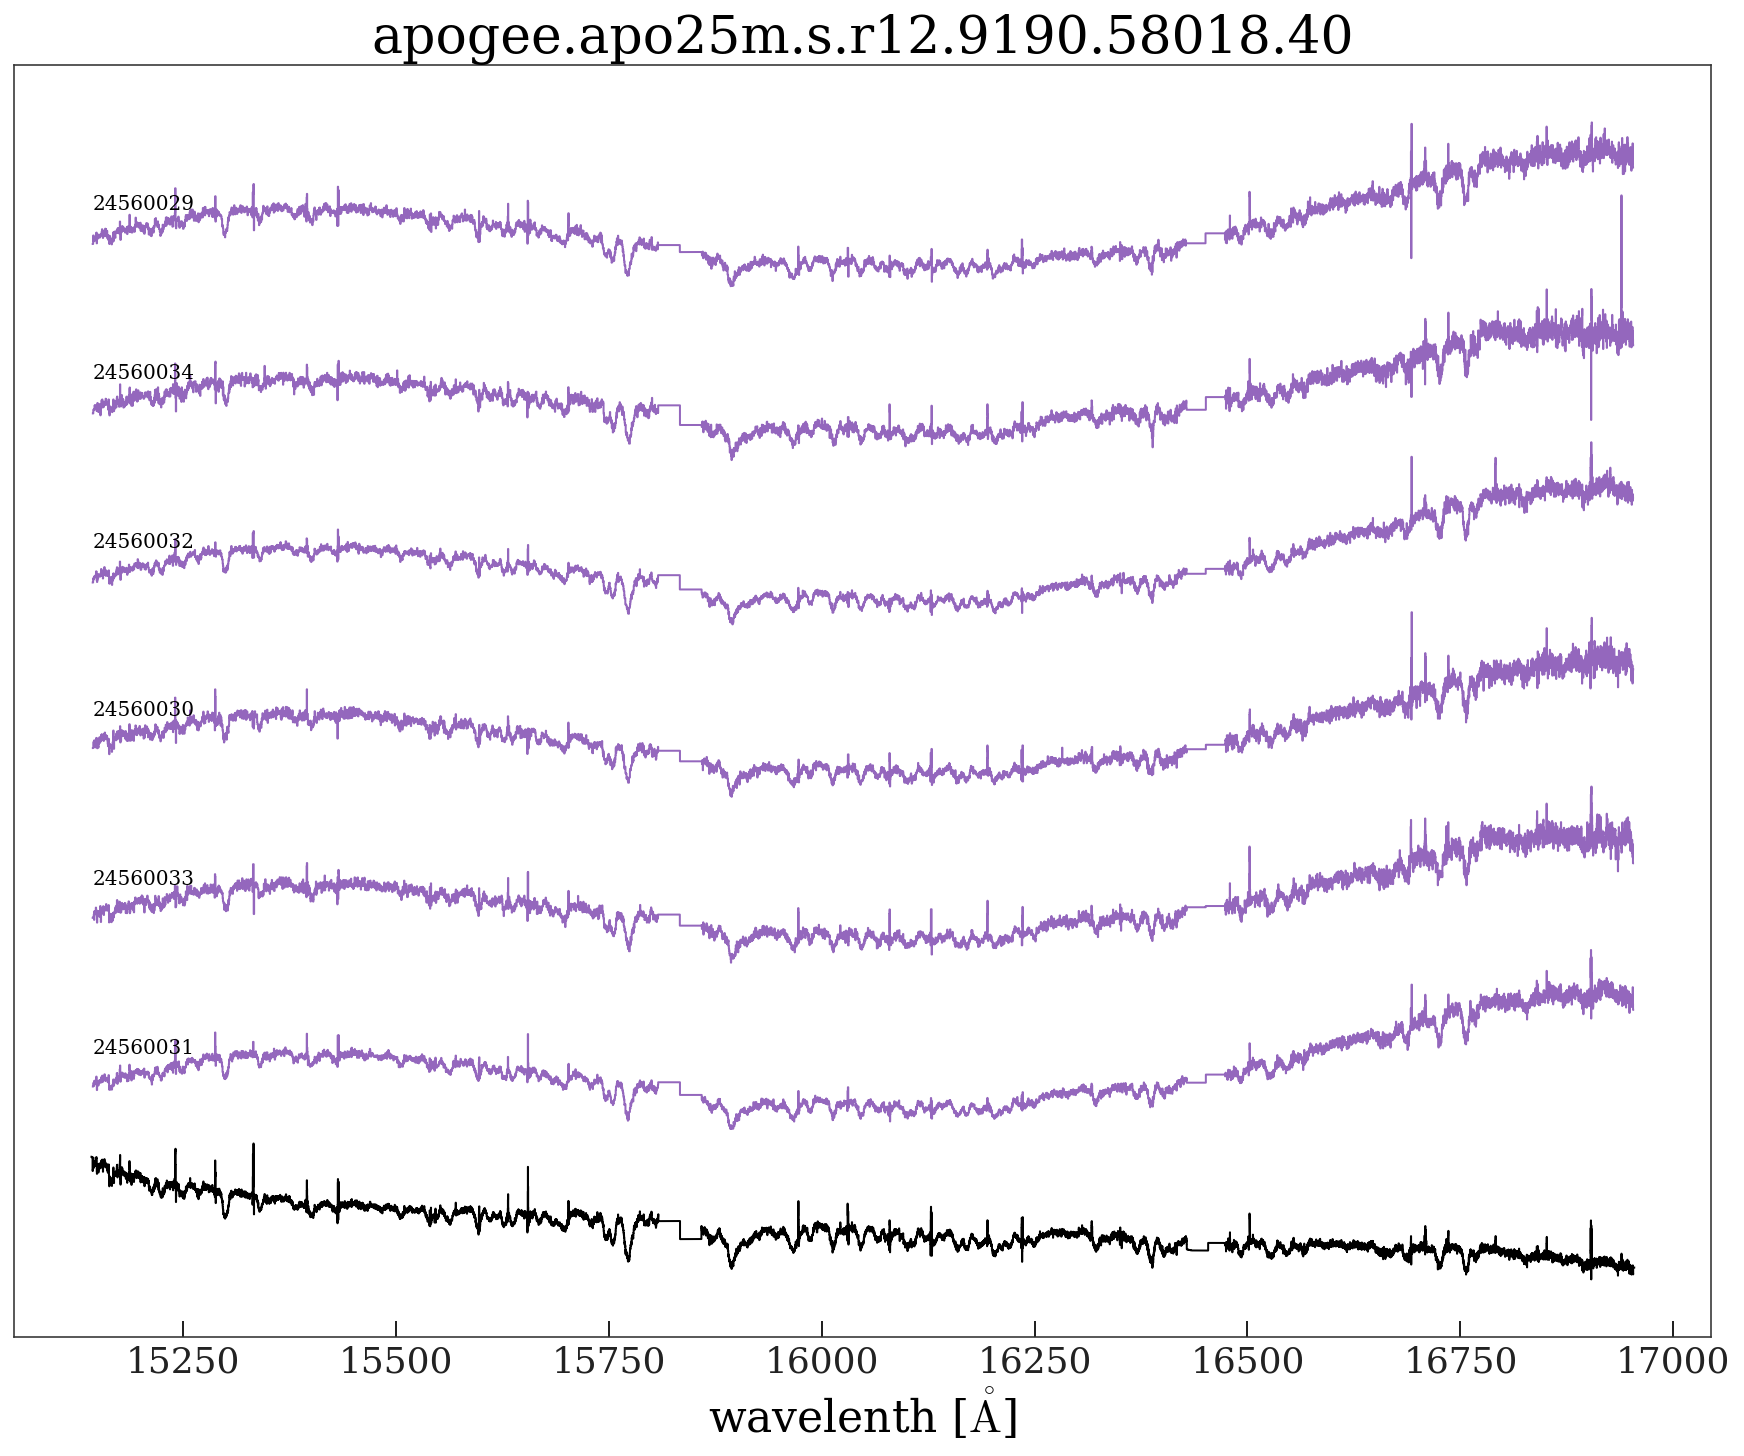

In [156]:
for visit in visits:
    fig, filename = plot_visit_frames(visit)
    fig.set_facecolor('w')

    filename.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(filename, dpi=250)
    break

---

In [157]:
mjds = []
cc_rvs = []
kernel_rvs = []
visit_vrels = []
rv_corrections = []

for visit in sorted(visits, key=lambda x: x['JD']):
# for visit in visits[:3]:
    spectra = visit.load_frame_spectra()
    
    for frame, s in spectra.items():
        print(frame)
        
        time = visit.frame_times[frame]
        
        normed_ref_spectrum = normalize_ref_to_frame(
            s, visit.spectrum, deg=7)
        
        fig, filename = plot_normalized_ref_spectrum(
            visit, frame,
            s, visit.spectrum, normed_ref_spectrum)
        filename.parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(filename, dpi=250)
        plt.close(fig)
        
#         cc, vs = cross_correlate(
#             s, normed_ref_spectrum, 
#             K_half=1)
        cc, vs = bag_of_hacks_cross_correlate(
            s, normed_ref_spectrum, 
            K_half=1)
        cc_dv, cc_poly = parabola_optimum(vs.value, cc)
        
        kernel, kernel_cov, vs = estimate_kernel(
            s, normed_ref_spectrum, 
            K_half=1)
        kern_dv = np.sum(kernel * vs.value) / np.sum(kernel)
        
        cc_rvs.append(cc_dv)
        kernel_rvs.append(kern_dv)
        visit_vrels.append(visit['VREL'])
        mjds.append(time.tcb.mjd)
        
        rv_correct = visit.skycoord.radial_velocity_correction(
            obstime=time, location=visit.earth_location).to_value(u.km/u.s)
        rv_corrections.append(rv_correct)
        
        # ---
#         fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
#                                  sharex=True)

#         ax = axes[0]
#         ax.errorbar(vs.value, kernel, np.sqrt(np.diag(kernel_cov)),
#                     marker='o', ls='none')

#         ax.axhline(0, zorder=-10, color='#aaaaaa')
#         ax.axhline(1, zorder=-10, color='#aaaaaa')
#         ax.axvline(kern_dv, color='tab:green')
#         ax.set_title(frame)

#         ax = axes[1]
#         ax.scatter(vs.value, (cc - 1) / 1e-3, color='#aaaaaa')
#         grid = np.linspace(vs.value.min(), vs.value.max(), 128)
#         ax.plot(grid, (cc_poly(grid) - 1) / 1e-3, marker='')
#         ax.axvline(cc_dv, color='tab:green')
#         #ax.set_ylim(0.999, 1.001)
#         fig.tight_layout()
        
mjds = np.array(mjds)
cc_rvs = np.array(cc_rvs)
kernel_rvs = np.array(kernel_rvs)
visit_vrels = np.array(visit_vrels)
rv_corrections = np.array(rv_corrections)

24560031
24560033
24560030
24560032
24560034
24560029
24600062
24600063
24600061
24600060
24600058
24600059
24790056
24790057
24790052
24790053
24790055
24790054
24800051
24800052
24800050
24800049
24800047
24800048
24810056
24810057
24810052
24810053
24810055
24810054
24880069
24880067
24880068
24880070
24880072
24880071
24890053
24890054
24890048
24890055
24890049
24890051
24890056
24890050
24890052
24890058
24890057
24890047
24900035
24900033
24900031
24900036
24900030
24900032
24900034
24900029
25080036
25080034
25080035
25080033
25080032
25080037
25090013
25090014
25090012
25090015
25090016
25090011


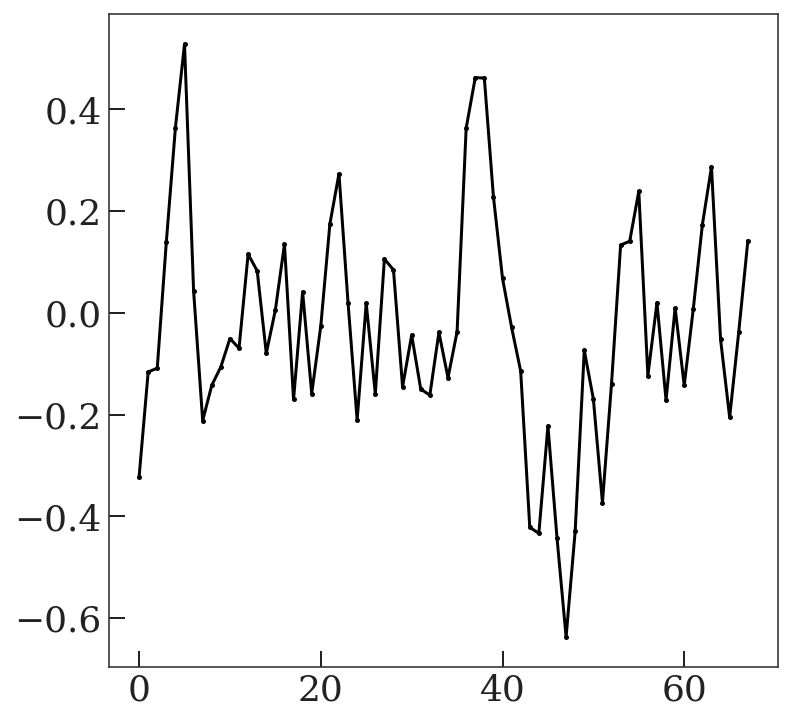

In [158]:
plt.plot(cc_rvs[mjds.argsort()], marker='.', ls='-')

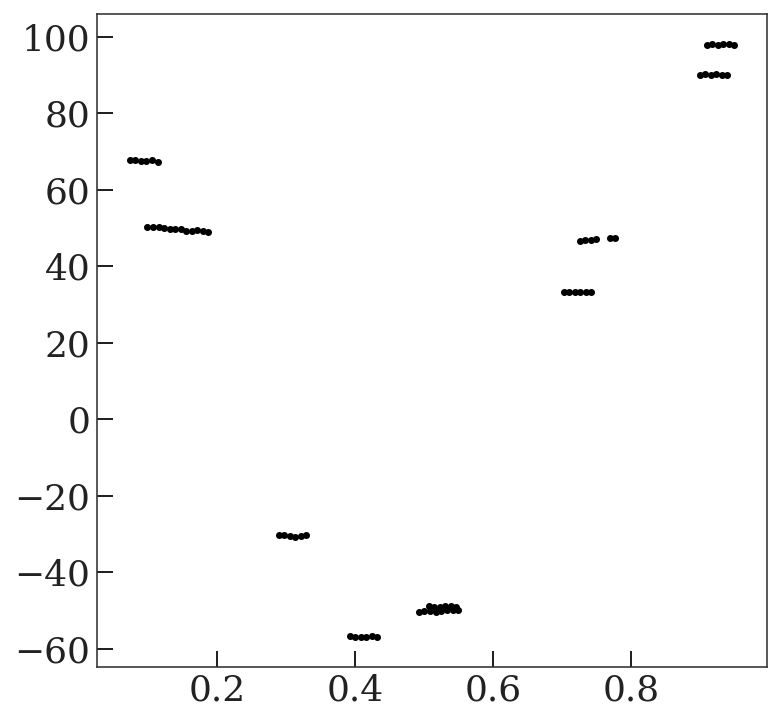

In [163]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
plt.scatter((mjds / P) % 1, rv_corrections + cc_rvs + visit_vrels, marker='.')

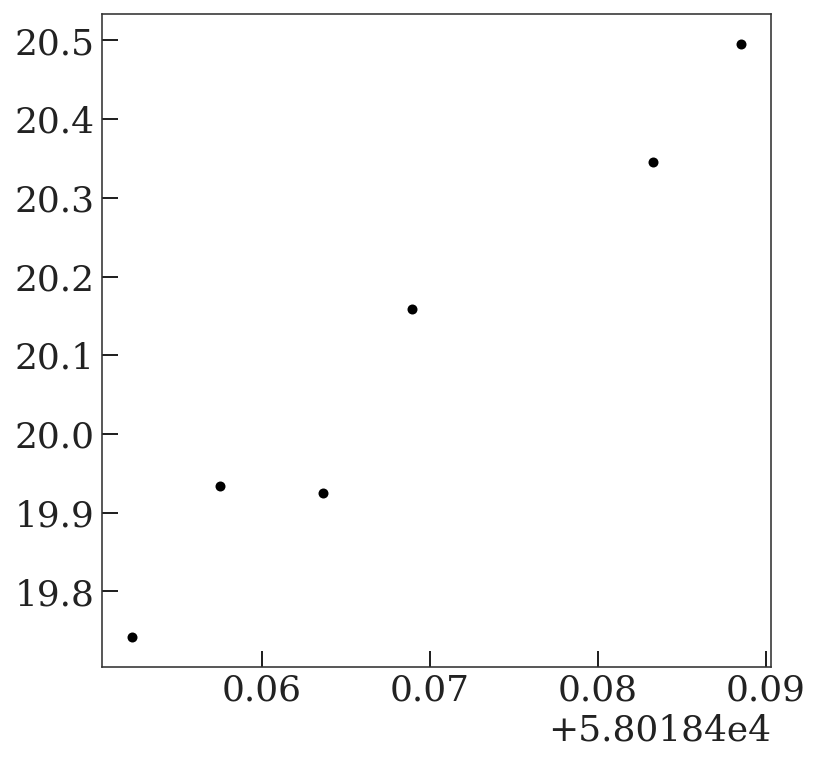

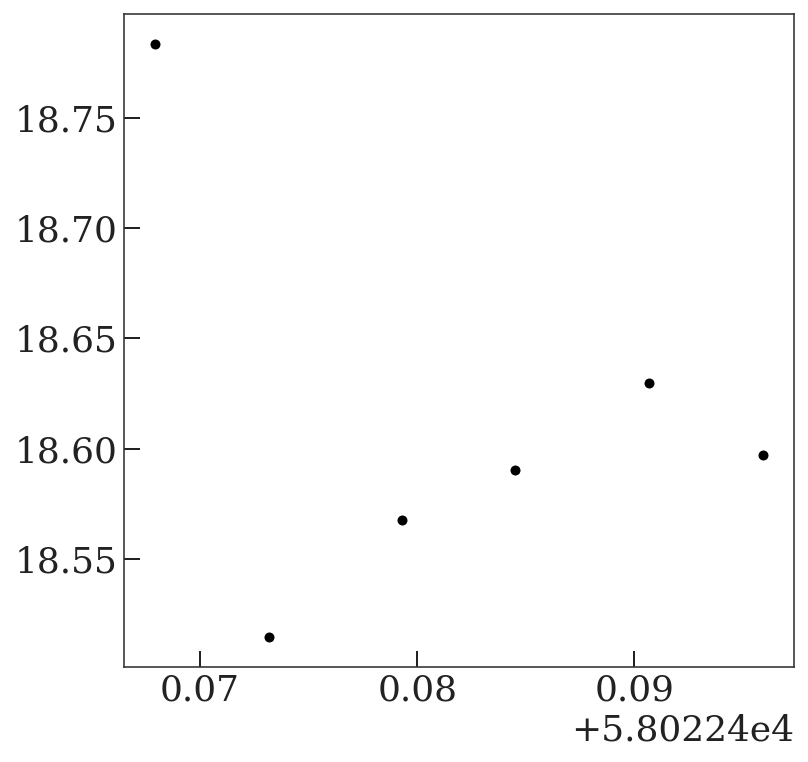

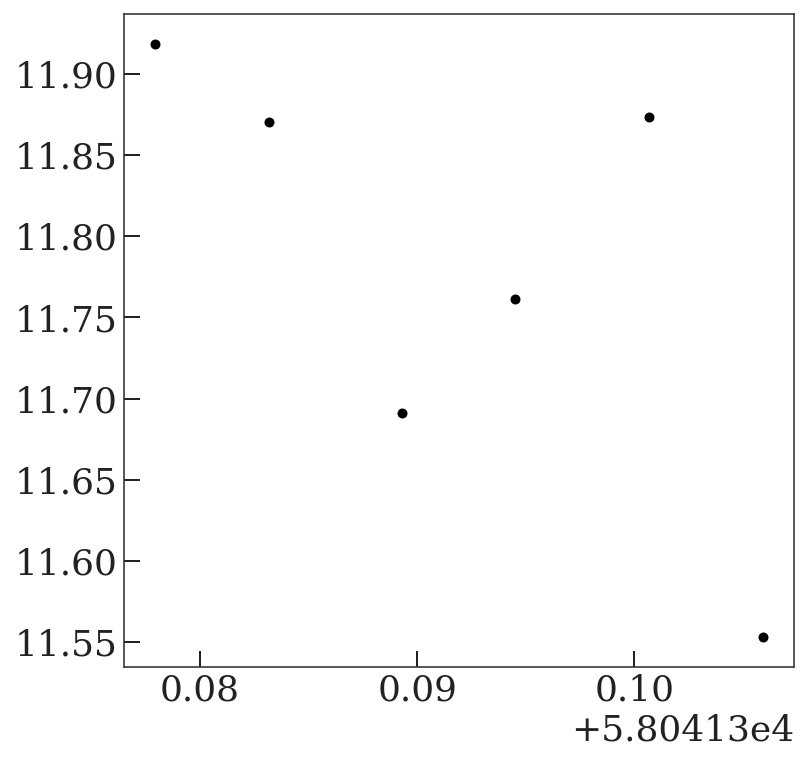

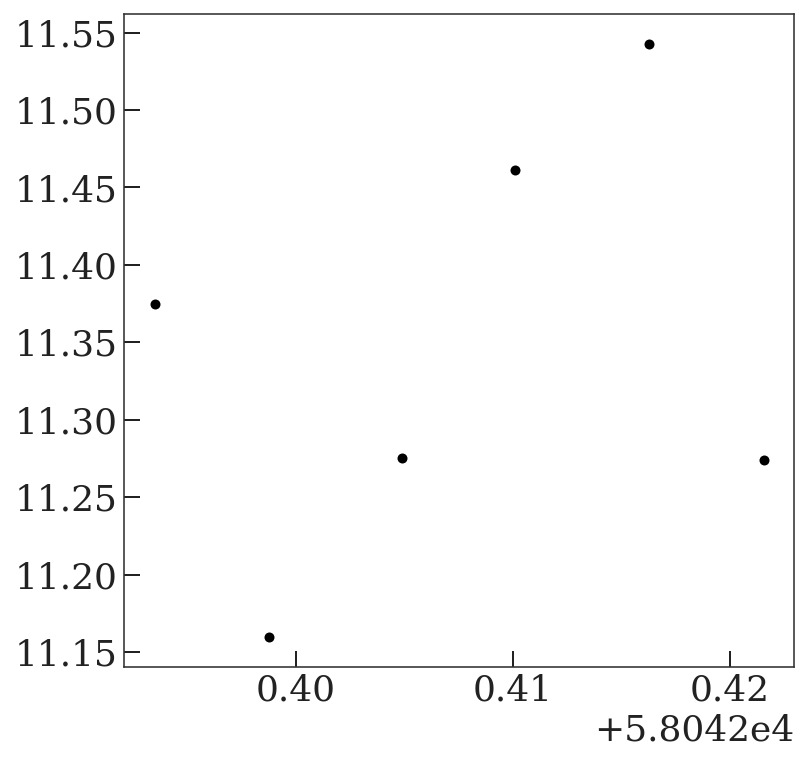

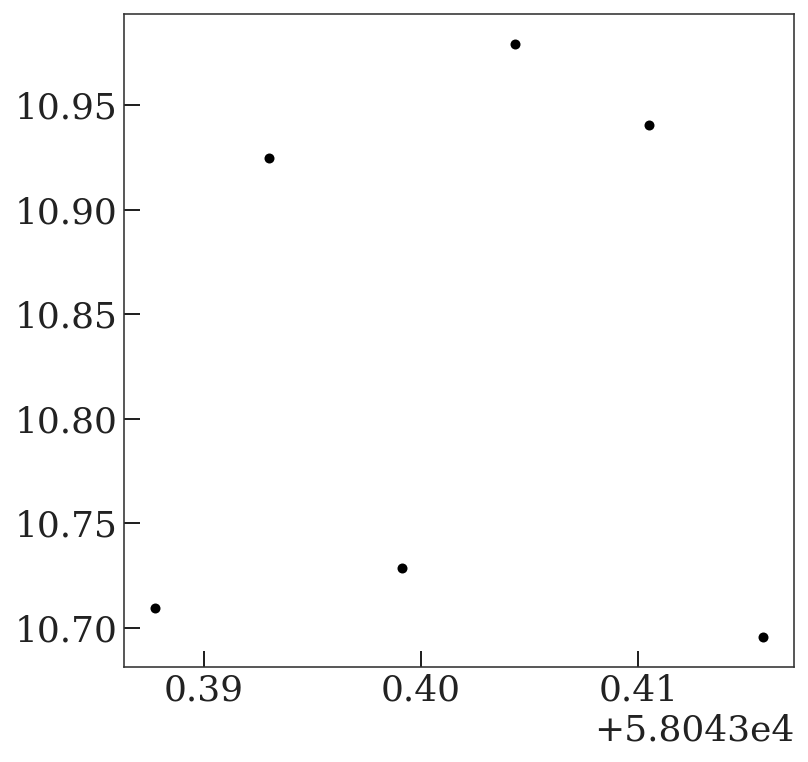

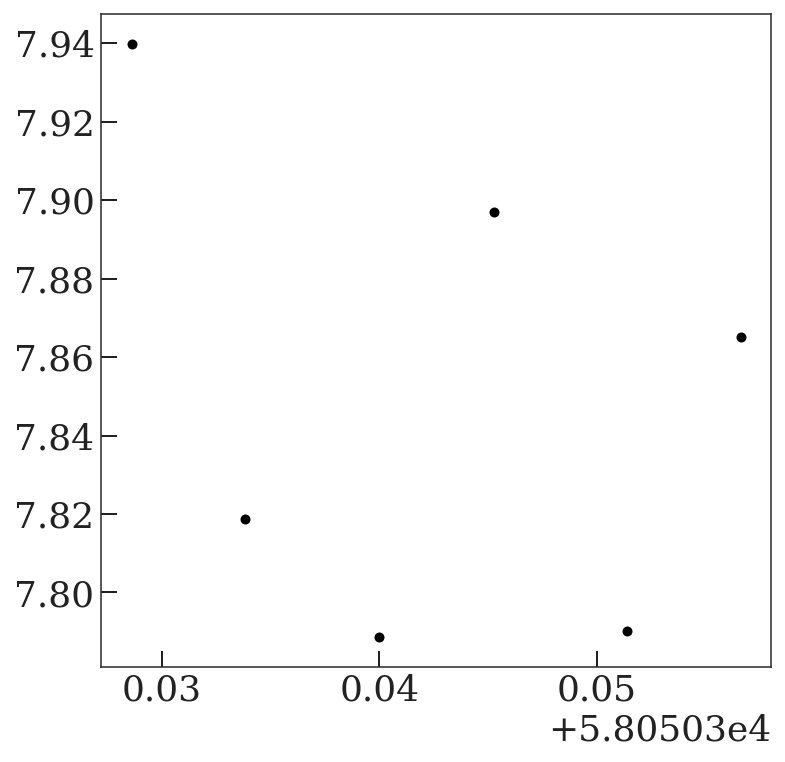

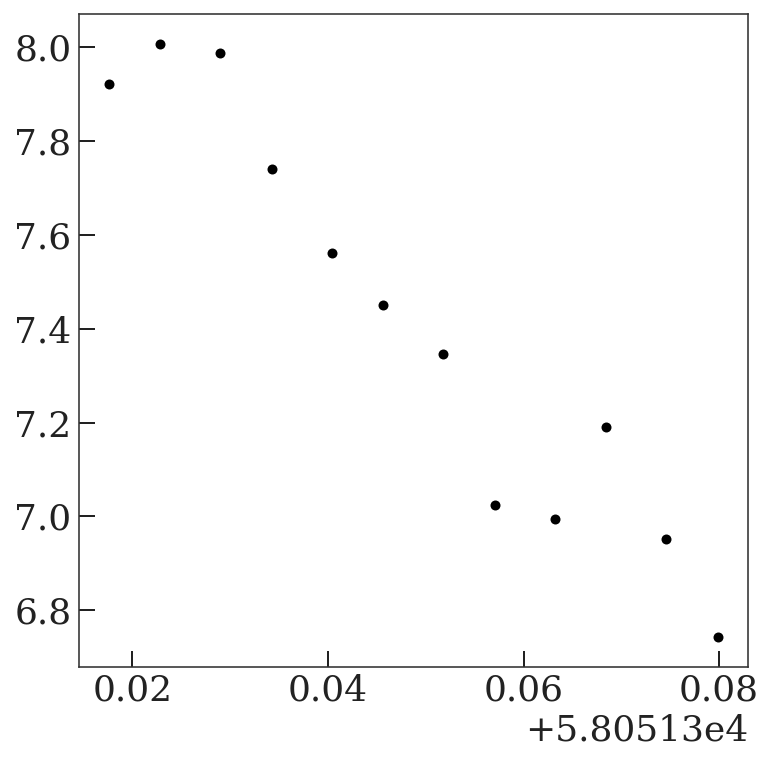

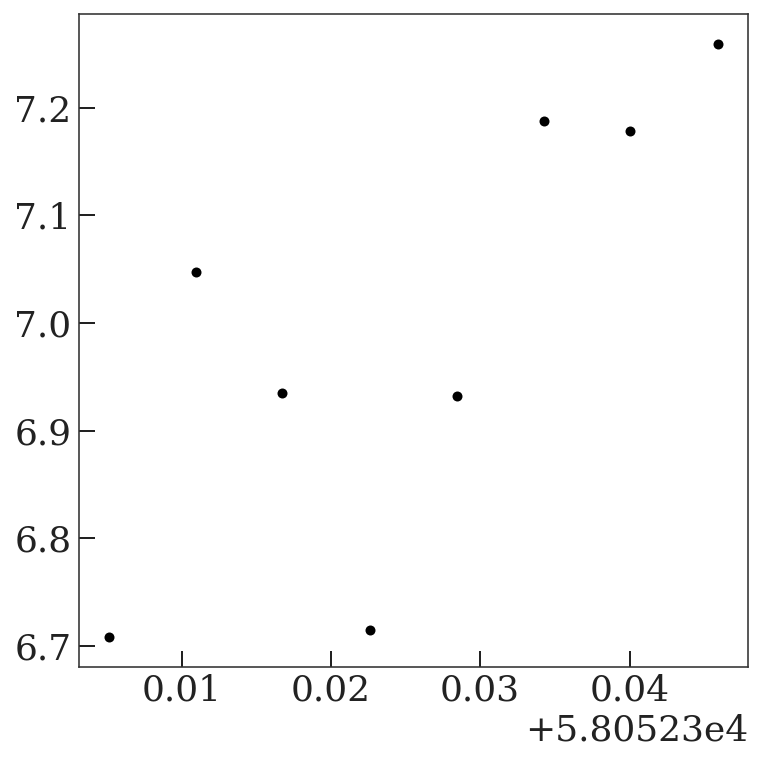

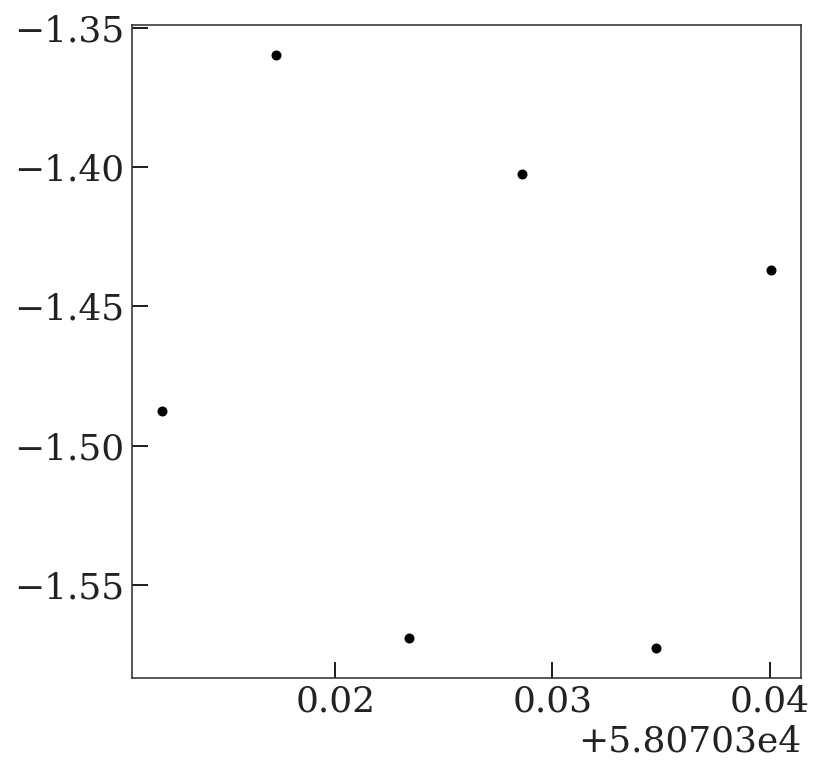

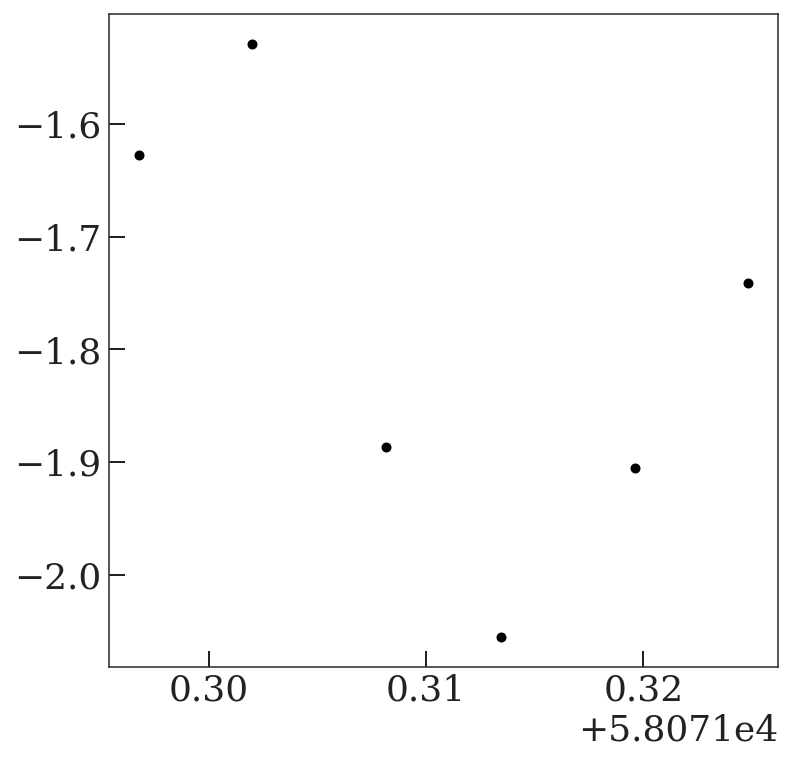

In [164]:
nights = mjds.astype(int)
for n in np.unique(nights):
    plt.figure()
    plt.plot(mjds[nights == n], (rv_corrections + cc_rvs)[nights == n],
             marker='o', ls='none')

(370, 375)

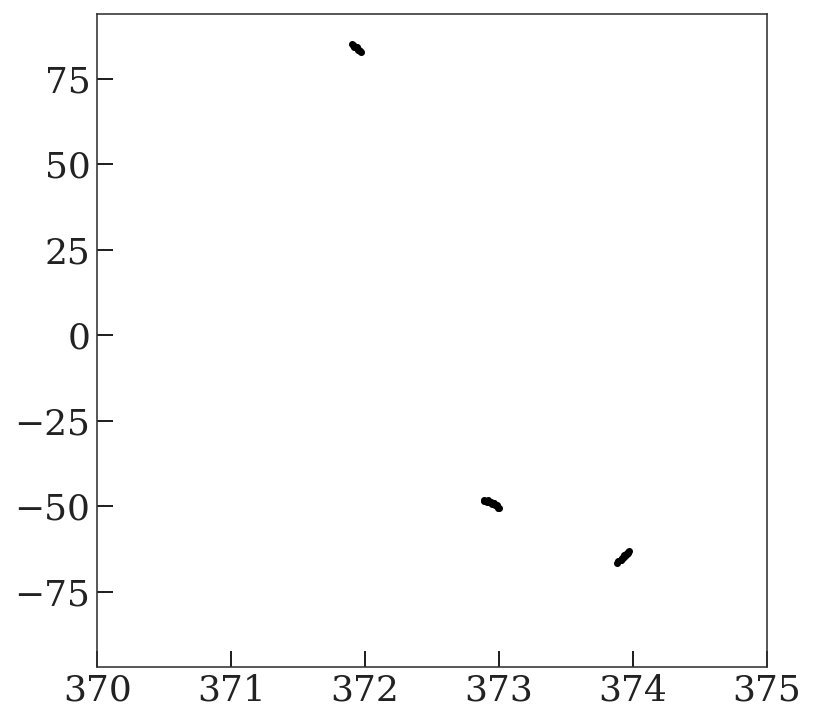

In [116]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
plt.scatter(mjds - mjds.min(), rv_corrections - cc_rvs + visit_vrels, marker='.')
plt.xlim(370, 375)

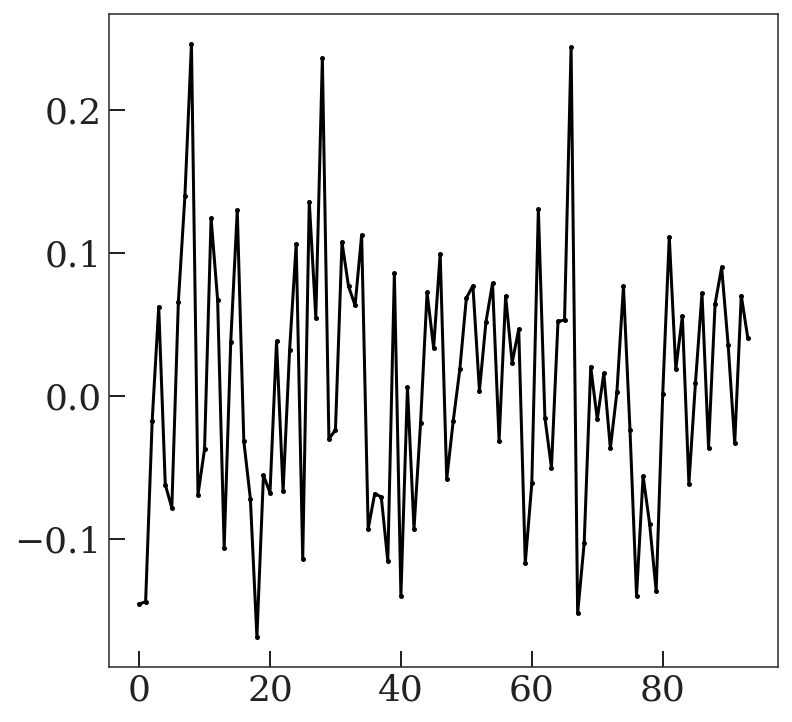

In [103]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, rv_corrections - cc_rvs + visit_vrels, marker='.')

# plt.scatter((mjds / 2.8753170) % 1, rv_corrections - cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, cc_rvs, marker='.')
plt.plot(cc_rvs[mjds.argsort()], marker='.', ls='-')

# plt.scatter(mjds, rv_corrections)

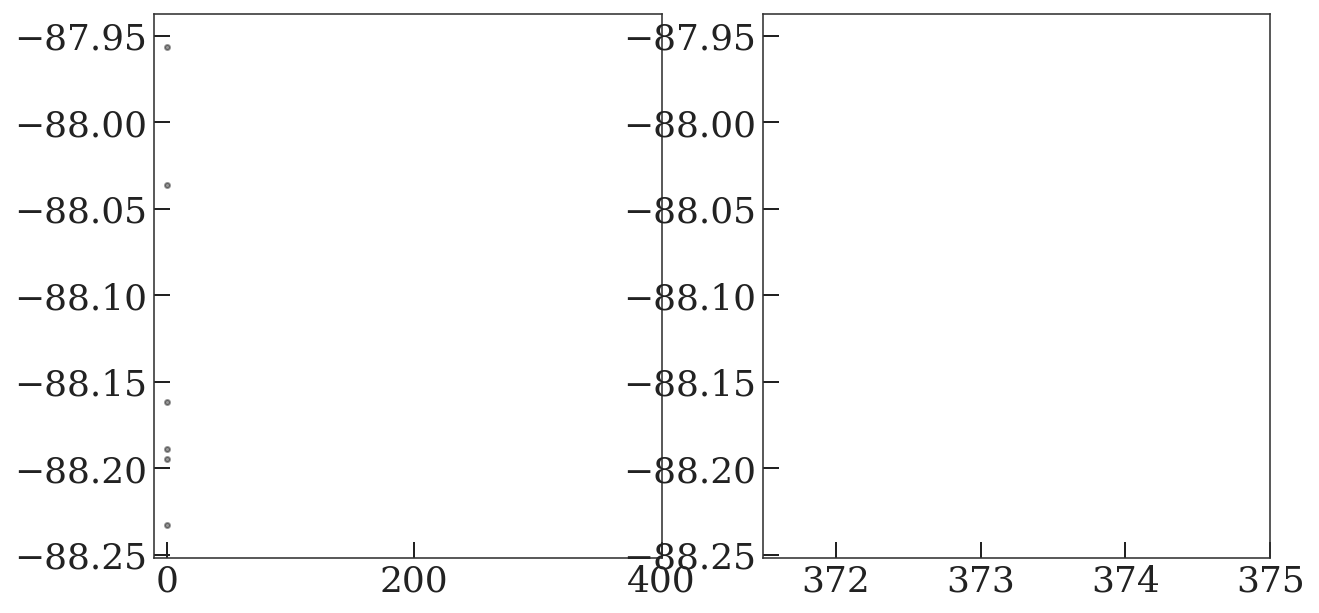

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)
    
fig.set_facecolor('w')

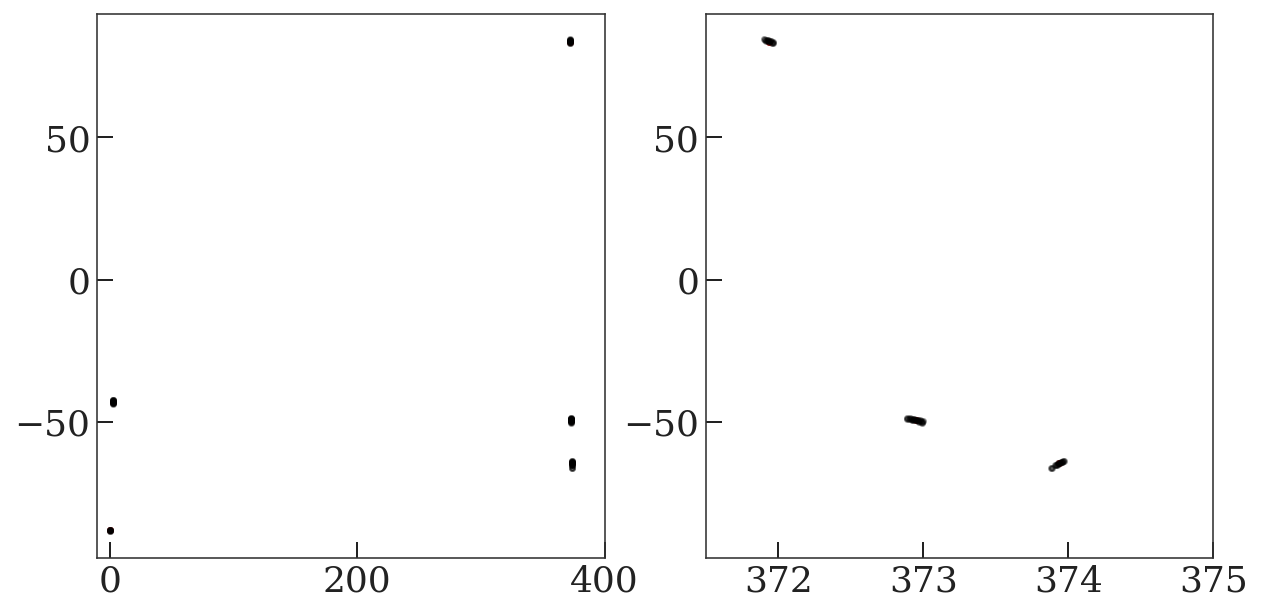

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)

for ax in axes:
    ax.scatter(Time(visits_tbl['JD'], format='jd').mjd - min(mjds),
               visits_tbl['VHELIO'],
               marker='.', color='tab:red', zorder=-100)
    
fig.set_facecolor('w')

(-20, 70)

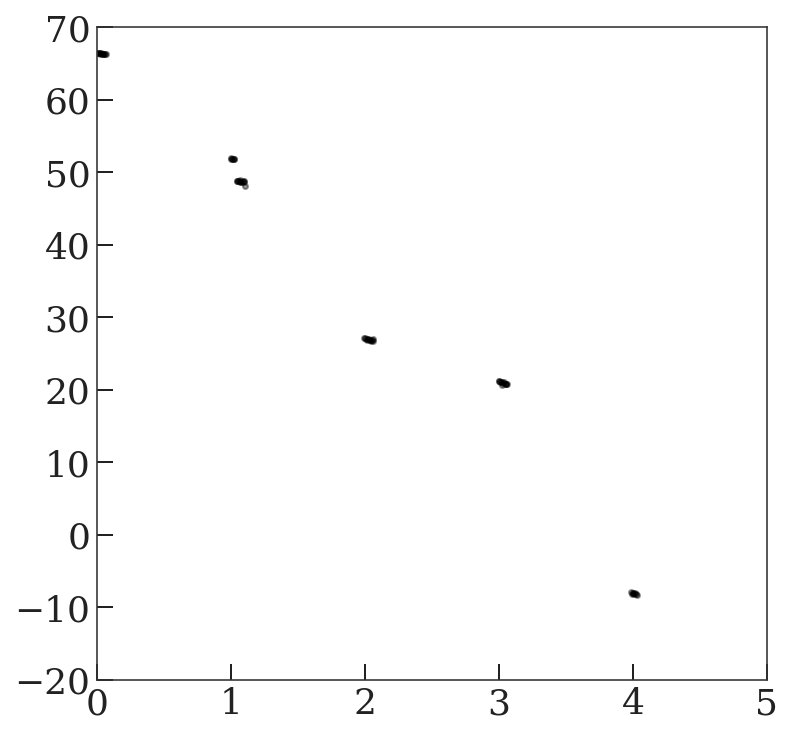

In [50]:
plt.scatter(mjds - min(mjds), kernel_rvs + visit_rvs, marker='.', alpha=0.4)
plt.xlim(0, 5)
plt.ylim(-20, 70)

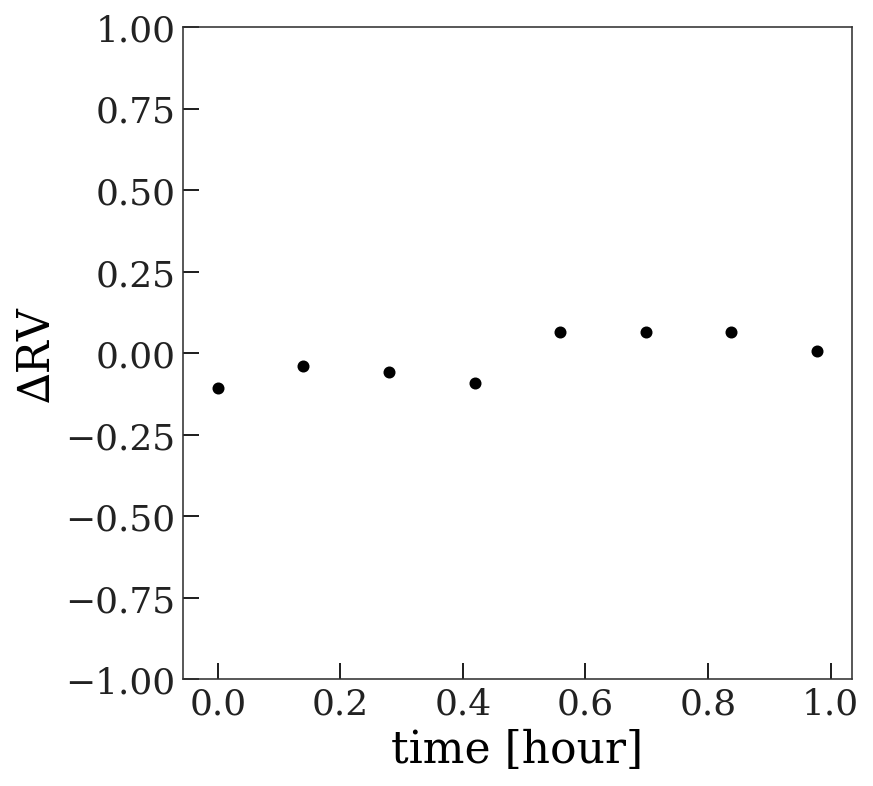

In [79]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
# plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
# plt.ylim(-5, 5)
plt.ylim(-1, 1)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)

In [24]:
from scipy.ndimage import gaussian_filter1d
from astropy.stats import sigma_clip

In [117]:
smooth = 100  # MAGIC

In [184]:
visit = visits[0]
spectra = visit.load_frame_spectra()

for frame, s in spectra.items():
    print(frame)

    time = visit.frame_times[frame]

    normed_ref_spectrum = normalize_ref_to_frame(
        s, visit.spectrum, deg=7)
    
    break

22950020


In [219]:
# f = normed_ref_spectrum.flux.copy()
# clipped_local = sigma_clip(f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1), 
#                            sigma=5, maxiters=10)

# fuck = f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1)

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, fuck)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          fuck[clipped_local.mask], color='r', ls='none', marker='.')

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, normed_ref_spectrum.flux)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          normed_ref_spectrum.flux[clipped_local.mask], 
#          color='r', ls='none', marker='.')

# normed_ref_spectrum = Spectrum1D(
#     f[~clipped_local.mask],
#     spectral_axis=normed_ref_spectrum.wavelength[~clipped_local.mask]
# )

In [186]:
# smooth_frame_flux = gaussian_filter1d(s.flux, sigma=smooth)
# frame_flux_diff = s.flux - smooth_frame_flux
# frame_flux_diff /= np.linalg.norm(frame_flux_diff)
# # plt.plot(frame_flux_diff)

In [187]:
# from subframe.velocity import shift_and_interpolate
# frame_spectrum = s

# shifted_flux = shift_and_interpolate(normed_ref_spectrum,
#                                      0,
#                                      frame_spectrum.wavelength)

# smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
# ref_flux_diff = shifted_flux - smooth_ref_flux
# ref_flux_diff /= np.linalg.norm(ref_flux_diff)

# clipped = sigma_clip(frame_flux_diff - ref_flux_diff, sigma=3)
# clip_mask = clipped.mask.copy()
# for shift in np.arange(-1, 1+1):
#     clip_mask |= np.roll(clip_mask, shift=shift)
# clip_mask[0] = clip_mask[-1] = 1

# print(clip_mask.sum())
# clipped_local = sigma_clip(frame_flux_diff - 0.5*np.roll(frame_flux_diff, 1) - 0.5*np.roll(frame_flux_diff, -1), 
#                            sigma=5)
# clip_mask |= clipped_local.mask
# print(clip_mask.sum())

488
489


In [188]:
# tmp = Spectrum1D(
#     shifted_flux[~clipped.mask] * u.one,
#     spectral_axis=frame_spectrum.wavelength[~clipped.mask])

In [189]:
dv = 8*u.km/u.s
vs = np.arange(-1, 1+1) * dv
terms = []
for v in vs:
    shifted_flux = shift_and_interpolate(normed_ref_spectrum,
                                         v,
                                         frame_spectrum.wavelength[~clip_mask])
    
    smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
    ref_flux_diff = shifted_flux - smooth_ref_flux
    ref_flux_diff /= np.linalg.norm(ref_flux_diff)
    
    terms.append(ref_flux_diff)

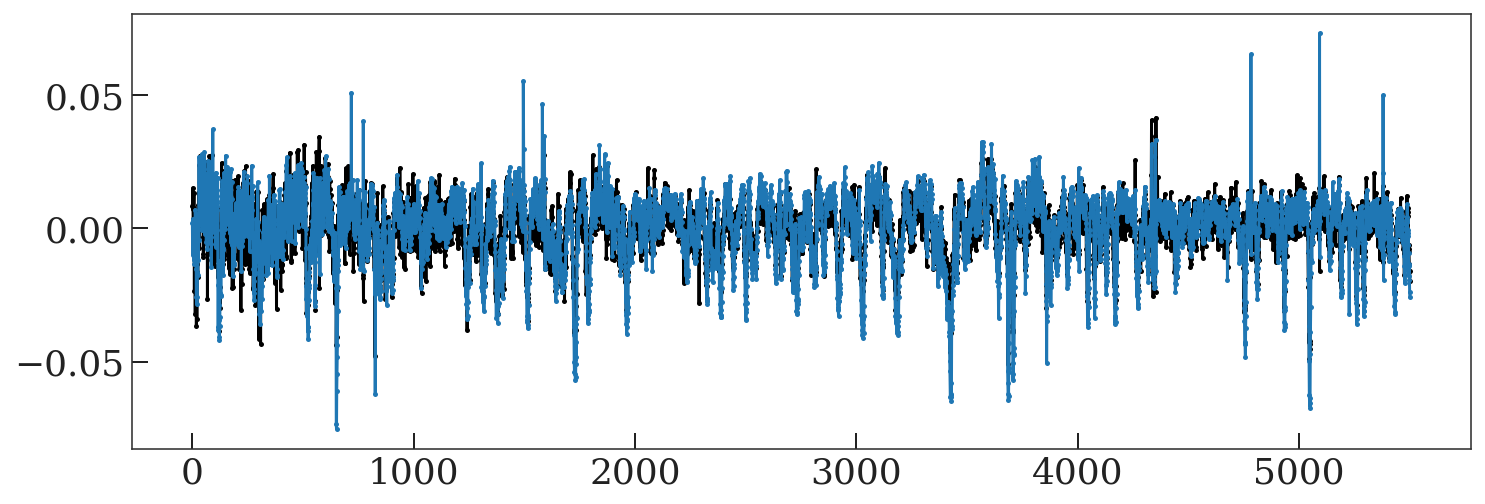

In [190]:
plt.figure(figsize=(12, 4))
plt.plot(frame_flux_diff[~clip_mask])
plt.plot(terms[0])

In [191]:
# M = np.stack(terms).T
# from subframe.utils import parabola_optimum

In [220]:
# Cinv = 1 / frame_spectrum.uncertainty.array**2

# # denom = np.sqrt(np.diag((M.T * Cinv) @ M) *
# #                 ((frame_spectrum.flux.T * Cinv) @ frame_spectrum.flux))
# # crosscorr = ((M.T * Cinv) @ frame_spectrum.flux) / denom

# cc = M.T @ frame_flux_diff[~clip_mask]

# cc_dv, _ = parabola_optimum(vs.value, cc)
# cc_dv

In [221]:
# cc, vs = cross_correlate(
#     s, normed_ref_spectrum, 
#     K_half=1)
# cc_dv_old, _ = parabola_optimum(vs.value, cc)
# cc_dv_old